************************************************************************************************************
* 题目：巴拉巴西-阿尔伯特网络 BA网络
* 制作者:版权所有,柳承睿、蒲鹏 Email:ppu@cc.ecnu.edu.cn；
* 最后更新日期：2022-6-1
* 补充掌握内容：https://blog.csdn.net/weixin_43957565/article/details/121200564
html  官方示例和JPT代码
* 声明：在转发并拷贝的过程中，请保留版权信息
************************************************************************************************************

In [68]:
import random
import time
import numpy as np
import pandas as pd
#加载依赖库
import networkx as nx
from matplotlib import pyplot as plt
#自定义函数
from mylib.mymath import random_unit
from mylib.mymath import log_binning  #对数分箱
from mylib.mymath import number_of_certain_prob  #根据概率分布，输出结果
import warnings
m=2 #每个节点带来两条边
totalT=10000 #实验观察 500个时间步
warnings.filterwarnings("ignore")

BB网络模拟

In [69]:
G_BB = nx.Graph()
nodes=pd.DataFrame()
edges=pd.DataFrame()
#生长参数 m=2 t=500
m=2 #每个节点带来两条边
totalT=10000 #实验观察 500个时间步
def draw_network_basic(G):
    degree_sequence = sorted((d for n, d in G.degree()), reverse=True)
    dmax = max(degree_sequence)
    fig = plt.figure("Degree of a random graph", figsize=(8, 8))
    # Create a gridspec for adding subplots of different sizes
    axgrid = fig.add_gridspec(5, 4)
    ax0 = fig.add_subplot(axgrid[0:3, :])
    Gcc = G.subgraph(sorted(nx.connected_components(G), key=len, reverse=True)[0])
    pos = nx.spring_layout(Gcc, seed=10396953)
    nx.draw_networkx_nodes(Gcc, pos, ax=ax0, node_size=20)
    nx.draw_networkx_edges(Gcc, pos, ax=ax0, alpha=0.4)
    ax0.set_title("Connected components of G")
    ax0.set_axis_off()
    ax1 = fig.add_subplot(axgrid[3:, :2])
    ax1.plot(degree_sequence, "b-", marker="o")
    ax1.set_title("Degree Rank Plot")
    ax1.set_ylabel("Degree")
    ax1.set_xlabel("Rank")
    ax2 = fig.add_subplot(axgrid[3:, 2:])
    ax2.bar(*np.unique(degree_sequence, return_counts=True))
    ax2.set_title("Degree histogram")
    ax2.set_xlabel("Degree")
    ax2.set_ylabel("# of Nodes")
    fig.tight_layout()
#  根据边的变化情况，更新网络
def update_network(showcontent=True):
        global G_BB 
        global edges
        # 生成新的图
        edges_not_active=edges[edges.active==0]
        #为了提升效率，只针对未被激活的边，进行添加。如果该边被添加过了，那么active设置为1
        for i,row in edges_not_active.iterrows():
                G_BB.add_edges_from([(row.n_start, row.n_end, {"weight":row.weight})])
                row.active=1
                edges.iloc[i] = row
        if(showcontent):
                draw_network_basic(G_BB)
#返回节点列表中所有节点的度/度综合（概率分布）
def getNodesP(temp_nodes):
    p_nodes=[]
    denominator = 0
    for index,raw in temp_nodes.iterrows():
        denominator += raw.d * raw.f
    for index,raw in temp_nodes.iterrows():
        # start----BB的定义，核心逻辑
        p=raw.d * raw.f / denominator #某个节点的概率
        p_nodes.append(p)
    return p_nodes  #返回所有节点的度/度综合（概率）
#网络初始化函数
def __init__(show_content=True):
    global G_BB 
    global edges
    global nodes
    G_BB = nx.Graph()
    #为了方便计算采用了dataframe数据结构存储节点
    # f:fitness 
    nodes=pd.DataFrame( [{"t":"t0","label":"n0","d":1,"f":np.random.rand()},{"t":"t0","label":"n1","d":1,"f":np.random.rand()}])
    print("---"*10)
    #假设是无权无向网络
    #t0时刻，初始化一条边，作为BA网络开始
    temp_list=[("t0",nodes.iloc[0,1],nodes.iloc[1,1],0,0)]
    edges=pd.DataFrame(temp_list,columns=['t','n_start','n_end','weight','active'])
    if(show_content):
        print("t0时间步点的集合：\n",nodes)
        print("t0时刻边的集合：\n",edges)
        print("开始初始化网络.......")
    update_network(show_content)

------------------------------
t0时间步点的集合：
     t label  d         f
0  t0    n0  1  0.588235
1  t0    n1  1  0.339251
t0时刻边的集合：
     t n_start n_end  weight  active
0  t0      n0    n1       0       0
开始初始化网络.......


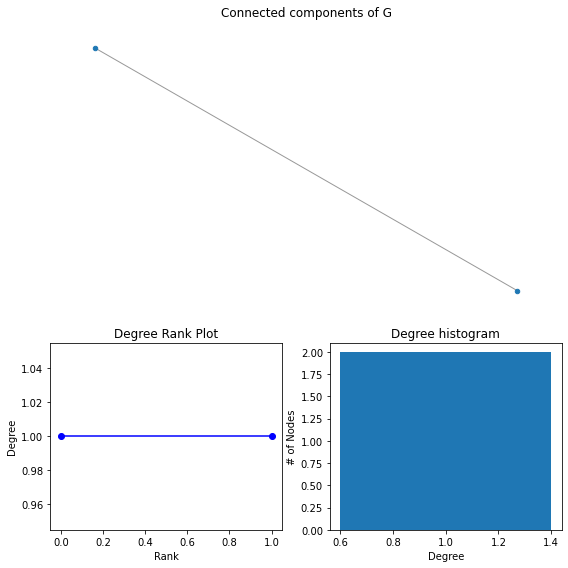

In [70]:
__init__()

步骤2 生长函数

In [71]:
# t---某个时刻  nums ----该时刻添加的节点的数量  
# edges_num--- 每个节点带来的边的数量  showcontent要不要显示图，单次生长可以观察图，多次生长看最后总图即可
def grows(t="t1",nodes_num=0,edges_num=0,showcontent=True):
    print(f"第{t}时刻正在生长.....,会生长{nodes_num}个节点，{edges_num}条边")
    global edges
    global nodes
    #前一个时刻的nodes长度
    ln=len(nodes)
    #组网前，对节点深拷贝做个备份，因为对同一个节点，每找到一个新边，旧的节点就得去掉，
    # 否则，容易两个边连接到同一个节点。
    temp_nodes=nodes.copy() 
    for k in range(0,nodes_num):#生成nodes_num个节点
        #每一个新来的节点
        if(edges_num==0):
            edges_num=np.random.randint(ln)  # 假设新节点带来的边数也是随机的，这个随机值必须小于节点数
        node_fitness = np.random.rand() # 适应度在0到1上均匀分布
        newnode_label="n"+str(k+ln)
        # # 让node100获得超大适应度
        # if t == "t1000": node_fitness = 3 
        # 赋予适应度
        newnode={"t":t,"label":newnode_label,"d":edges_num,"f":node_fitness} #新节点的度肯定是，它带来的边的数量
        
        print(f"第{t}时刻{k+1}个新的节点{newnode_label}带来了{edges_num}条边, 该节点适应度为{node_fitness}")
        # 对一个新节点，要处理它的每一条新增的边，都要按照概率从原有的节点中，找到一个去组成边
        for m0 in range(0,edges_num): 
            #按照概率找出合适的节点findnodeByP
            findnodeByP = number_of_certain_prob(list(temp_nodes.label), getNodesP(temp_nodes))  
            print(f"第{m0+1}条边，链接到节点{findnodeByP}----->{newnode_label}")
            #组建新边
            new_edge={'t': t,"n_start":findnodeByP,"n_end":newnode["label"],"weight":0,"active":0}
            edges=edges.append(new_edge, ignore_index=True)
            #更新 findnodeByP 的度
            nodes.loc[nodes.label==findnodeByP,'d']+=1
            #组建好边的节点，删除之，下次组边就不会选择这个节点
            temp_nodes=temp_nodes.drop(temp_nodes.index[temp_nodes.label==findnodeByP])
        #新节点的所有边，都插入到网络中，新节点插到节点表中
        nodes=nodes.append(newnode, ignore_index=True)
    #更新网络
    update_network(showcontent)


步骤3 模拟生长

------------------------------
第t1时刻正在生长.....,会生长1个节点，2条边
第t1时刻1个新的节点n2带来了2条边, 该节点适应度为0.7750649289973917
第1条边，链接到节点n0----->n2
第2条边，链接到节点n1----->n2
第t2时刻正在生长.....,会生长1个节点，2条边
第t2时刻1个新的节点n3带来了2条边, 该节点适应度为0.8503766175981855
第1条边，链接到节点n2----->n3
第2条边，链接到节点n1----->n3
第t3时刻正在生长.....,会生长1个节点，2条边
第t3时刻1个新的节点n4带来了2条边, 该节点适应度为0.2176803420452471
第1条边，链接到节点n2----->n4
第2条边，链接到节点n0----->n4
第t4时刻正在生长.....,会生长1个节点，2条边
第t4时刻1个新的节点n5带来了2条边, 该节点适应度为0.20429609897687107
第1条边，链接到节点n4----->n5
第2条边，链接到节点n3----->n5
第t5时刻正在生长.....,会生长1个节点，2条边
第t5时刻1个新的节点n6带来了2条边, 该节点适应度为0.06022460617835257
第1条边，链接到节点n2----->n6
第2条边，链接到节点n3----->n6
第t6时刻正在生长.....,会生长1个节点，2条边
第t6时刻1个新的节点n7带来了2条边, 该节点适应度为0.9198567841489782
第1条边，链接到节点n3----->n7
第2条边，链接到节点n2----->n7
第t7时刻正在生长.....,会生长1个节点，2条边
第t7时刻1个新的节点n8带来了2条边, 该节点适应度为0.8493322764321454
第1条边，链接到节点n7----->n8
第2条边，链接到节点n4----->n8
第t8时刻正在生长.....,会生长1个节点，2条边
第t8时刻1个新的节点n9带来了2条边, 该节点适应度为0.8572753899551256
第1条边，链接到节点n3----->n9
第2条边，链接到节点n0----->n9
第t9时刻正在生长.....,会生长1个节点，2条边
第t9时刻1个新的节点n

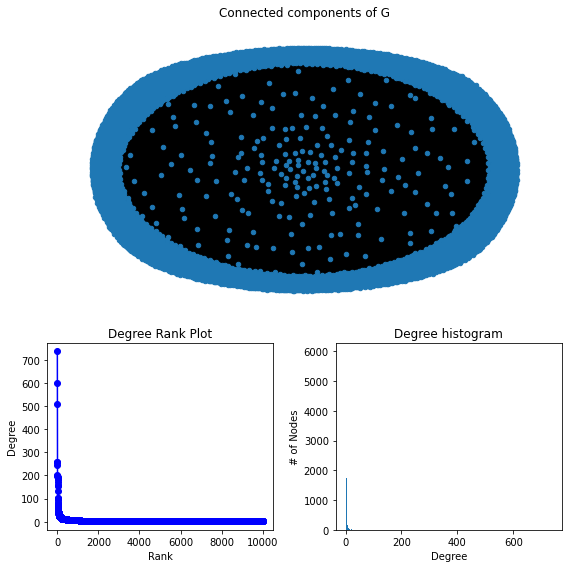

In [72]:
__init__(show_content=False) #初始化
#生长参数 每个时间步，增加m=2条边，1个节点，总共模拟 totalT=500
for i in range(1,totalT):
    grows("t"+str(i),1,m,False)
    #time.sleep(0.1)  #不加等待貌似会报错，承睿也可以优化
nodes.to_csv(f"{totalT}nodesBBnodes.csv")
edges.to_csv(f"{totalT}nodesBBedges.csv")
draw_network_basic(G_BB)

In [73]:
nodes = pd.DataFrame(pd.read_csv("1000nodesBBnodes.csv"))
edges = pd.DataFrame(pd.read_csv("1000nodesBBedges.csv"))

步骤4 度分布

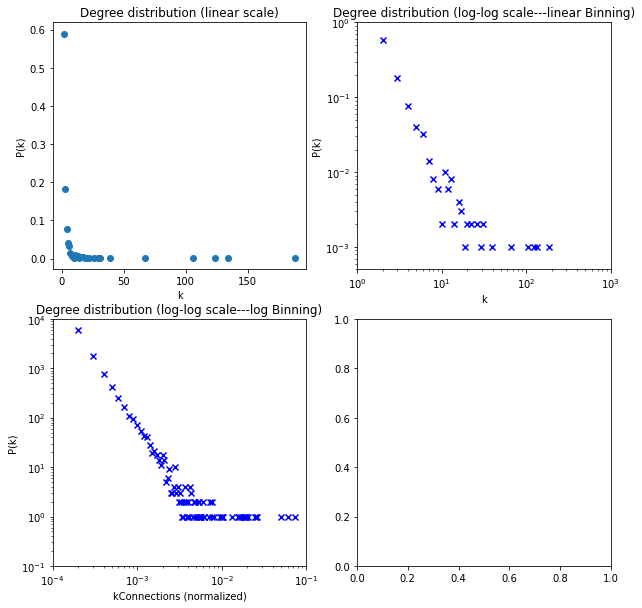

In [74]:
from collections import Counter
fig2v2New=plt.figure(figsize=(10 ,10))
ax4_1=fig2v2New.add_subplot(2,2,1)
ax4_2=plt.subplot(2,2,2)  #等效于ax4_2=fig2v2New.add_subplot(2,2,2)
ax4_3=fig2v2New.add_subplot(2,2,3)
ax4_4=fig2v2New.add_subplot(2,2,4)
k_list=[]
pk_list=[]
c=Counter(nodes.d)
#按照值从小到大排序
cc=sorted(c.items(),key=lambda x:x[0]) 
#print(cc)
#线性标度图
for tmpk_nums in cc:
    k_list.append(tmpk_nums[0])
    pk_list.append(tmpk_nums[1]/len(nodes))

ax4_1.set_title('Degree distribution (linear scale)')
ax4_1.set_ylabel('P(k)')
ax4_1.set_xlabel('k')
ax4_1.scatter(k_list,pk_list)
#双对数坐标-----线性分箱
ax4_2.set_xscale("log")
ax4_2.set_yscale("log")
ax4_2.set_title('Degree distribution (log-log scale---linear Binning)')
ax4_2.set_ylabel('P(k)')
ax4_2.set_xlabel('k')
ax4_2.set_xlim((1,1e3))
ax4_2.set_ylim((5*1e-4,1))
ax4_2.scatter(k_list,pk_list,c='b',marker='x')
#双对数坐标-----对数分箱
ba_c = nx.degree_centrality(G_BB)
# To convert normalized degrees to raw degrees
ba_c2 = dict(Counter(ba_c.values()))
# 这个函数我不知道是不是写错了，书上的log binning图非常好看，我这个感觉和线性binning没区别
#书上page176
ba_x,ba_y = log_binning(ba_c2,50)
ax4_3.set_xscale("log")
ax4_3.set_yscale("log")
ax4_3.set_title('Degree distribution (log-log scale---log Binning)')
ax4_3.set_ylabel('P(k)')
ax4_3.set_xlabel('kConnections (normalized)')
ax4_3.set_xlim((1e-4,1e-1))
ax4_3.set_ylim((1e-1,1e4))
# ax4_3.scatter(ba_x,ba_y,c='r',marker='s',s=50)
ax4_3.scatter(ba_c2.keys(),ba_c2.values(),c='b',marker='x')

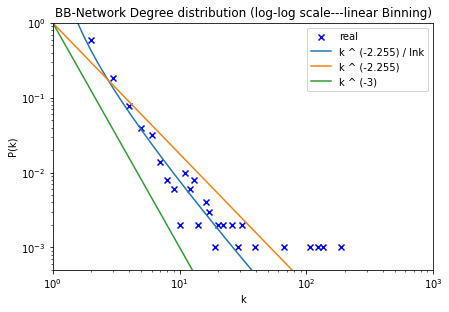

In [83]:
from collections import Counter

x = np.arange(0, 1e3, 0.1)
y_1 = x ** (-1.75) / np.log(x)
y_2 = x ** (-1.75) 
y_3 = x ** (-3)


fig2v2New=plt.figure(figsize=(15 ,10))
ax4_2=plt.subplot(2,2,2)  #等效于ax4_2=fig2v2New.add_subplot(2,2,2)
k_list=[]
pk_list=[]
c=Counter(nodes.d)
#按照值从小到大排序
cc=sorted(c.items(),key=lambda x:x[0]) 
for tmpk_nums in cc:
    k_list.append(tmpk_nums[0])
    pk_list.append(tmpk_nums[1]/len(nodes))
#双对数坐标-----线性分箱
ax4_2.set_xscale("log")
ax4_2.set_yscale("log")
ax4_2.set_title('BB-Network Degree distribution (log-log scale---linear Binning)')
ax4_2.set_ylabel('P(k)')
ax4_2.set_xlabel('k')
ax4_2.set_xlim((1,1e3))
ax4_2.set_ylim((5*1e-4,1))
ax4_2.scatter(k_list,pk_list,c='b',marker='x')
ax4_2.plot(x, y_1)
ax4_2.plot(x, y_2)
ax4_2.plot(x, y_3)
ax4_2.legend(['real','k ^ (-2.255) / lnk','k ^ (-2.255) ','k ^ (-3)'])


In [76]:
print ("所有节点的度",G_BB.degree() )                                    #返回所有节点的度
print ("所有节点的度分布序列:",nx.degree_histogram(G_BB))    #返回图中所有节点的度分布序列（从1至最大度的出现频次）

所有节点的度 [('n0', 7), ('n1', 16), ('n2', 508), ('n3', 736), ('n4', 10), ('n5', 10), ('n6', 3), ('n7', 599), ('n8', 185), ('n9', 257), ('n10', 11), ('n11', 43), ('n12', 11), ('n13', 77), ('n14', 10), ('n15', 194), ('n16', 72), ('n17', 8), ('n18', 158), ('n19', 4), ('n20', 245), ('n21', 7), ('n22', 2), ('n23', 14), ('n24', 3), ('n25', 18), ('n26', 24), ('n27', 183), ('n28', 2), ('n29', 131), ('n30', 48), ('n31', 34), ('n32', 2), ('n33', 2), ('n34', 47), ('n35', 258), ('n36', 25), ('n37', 3), ('n38', 22), ('n39', 204), ('n40', 3), ('n41', 52), ('n42', 12), ('n43', 72), ('n44', 3), ('n45', 3), ('n46', 196), ('n47', 38), ('n48', 60), ('n49', 2), ('n50', 8), ('n51', 95), ('n52', 10), ('n53', 2), ('n54', 40), ('n55', 2), ('n56', 5), ('n57', 171), ('n58', 12), ('n59', 80), ('n60', 17), ('n61', 17), ('n62', 25), ('n63', 7), ('n64', 12), ('n65', 5), ('n66', 2), ('n67', 2), ('n68', 4), ('n69', 71), ('n70', 13), ('n71', 37), ('n72', 15), ('n73', 12), ('n74', 76), ('n75', 8), ('n76', 3), ('n77', 10), 

## 实验2 网络动力学

### 步骤1 网络中度的变化和生长时刻的幂指数关系beita的验证

In [77]:
#观察某个时刻开始，到最终时刻，该时刻新增节点的度的变化
def degree_increase(t=0):
    global totalT
    x_list=[]
    k_list=[]
    n_lable="n"+str(t+1)
    for ti in range(t,totalT):
        
        x_list.append(ti)
        if ti==0: #此时只考虑两个节点n0和n1
            k_list.append(2)
            continue
        tlabel="t"+str(ti) #时刻的标签
        if t==0: #这个时刻点就是为了观察n0和n1
            l1=len(edges[(edges.t==tlabel)&(edges.n_start=='n0')])
            l2=len(edges[(edges.t==tlabel)&(edges.n_start=='n1')])
            k_list.append(k_list[ti-1]+l1+l2)
        else:
            #根据边的数量计算度
            l1=len(edges[(edges.t==tlabel)&(edges.n_start==n_lable)])
            l2=len(edges[(edges.t==tlabel)&(edges.n_end==n_lable)])
            if(k_list==[]):
                k_list.append(l1+l2)
            else:
                k_list.append(k_list[ti-t-1]+l1+l2)
    return x_list,k_list

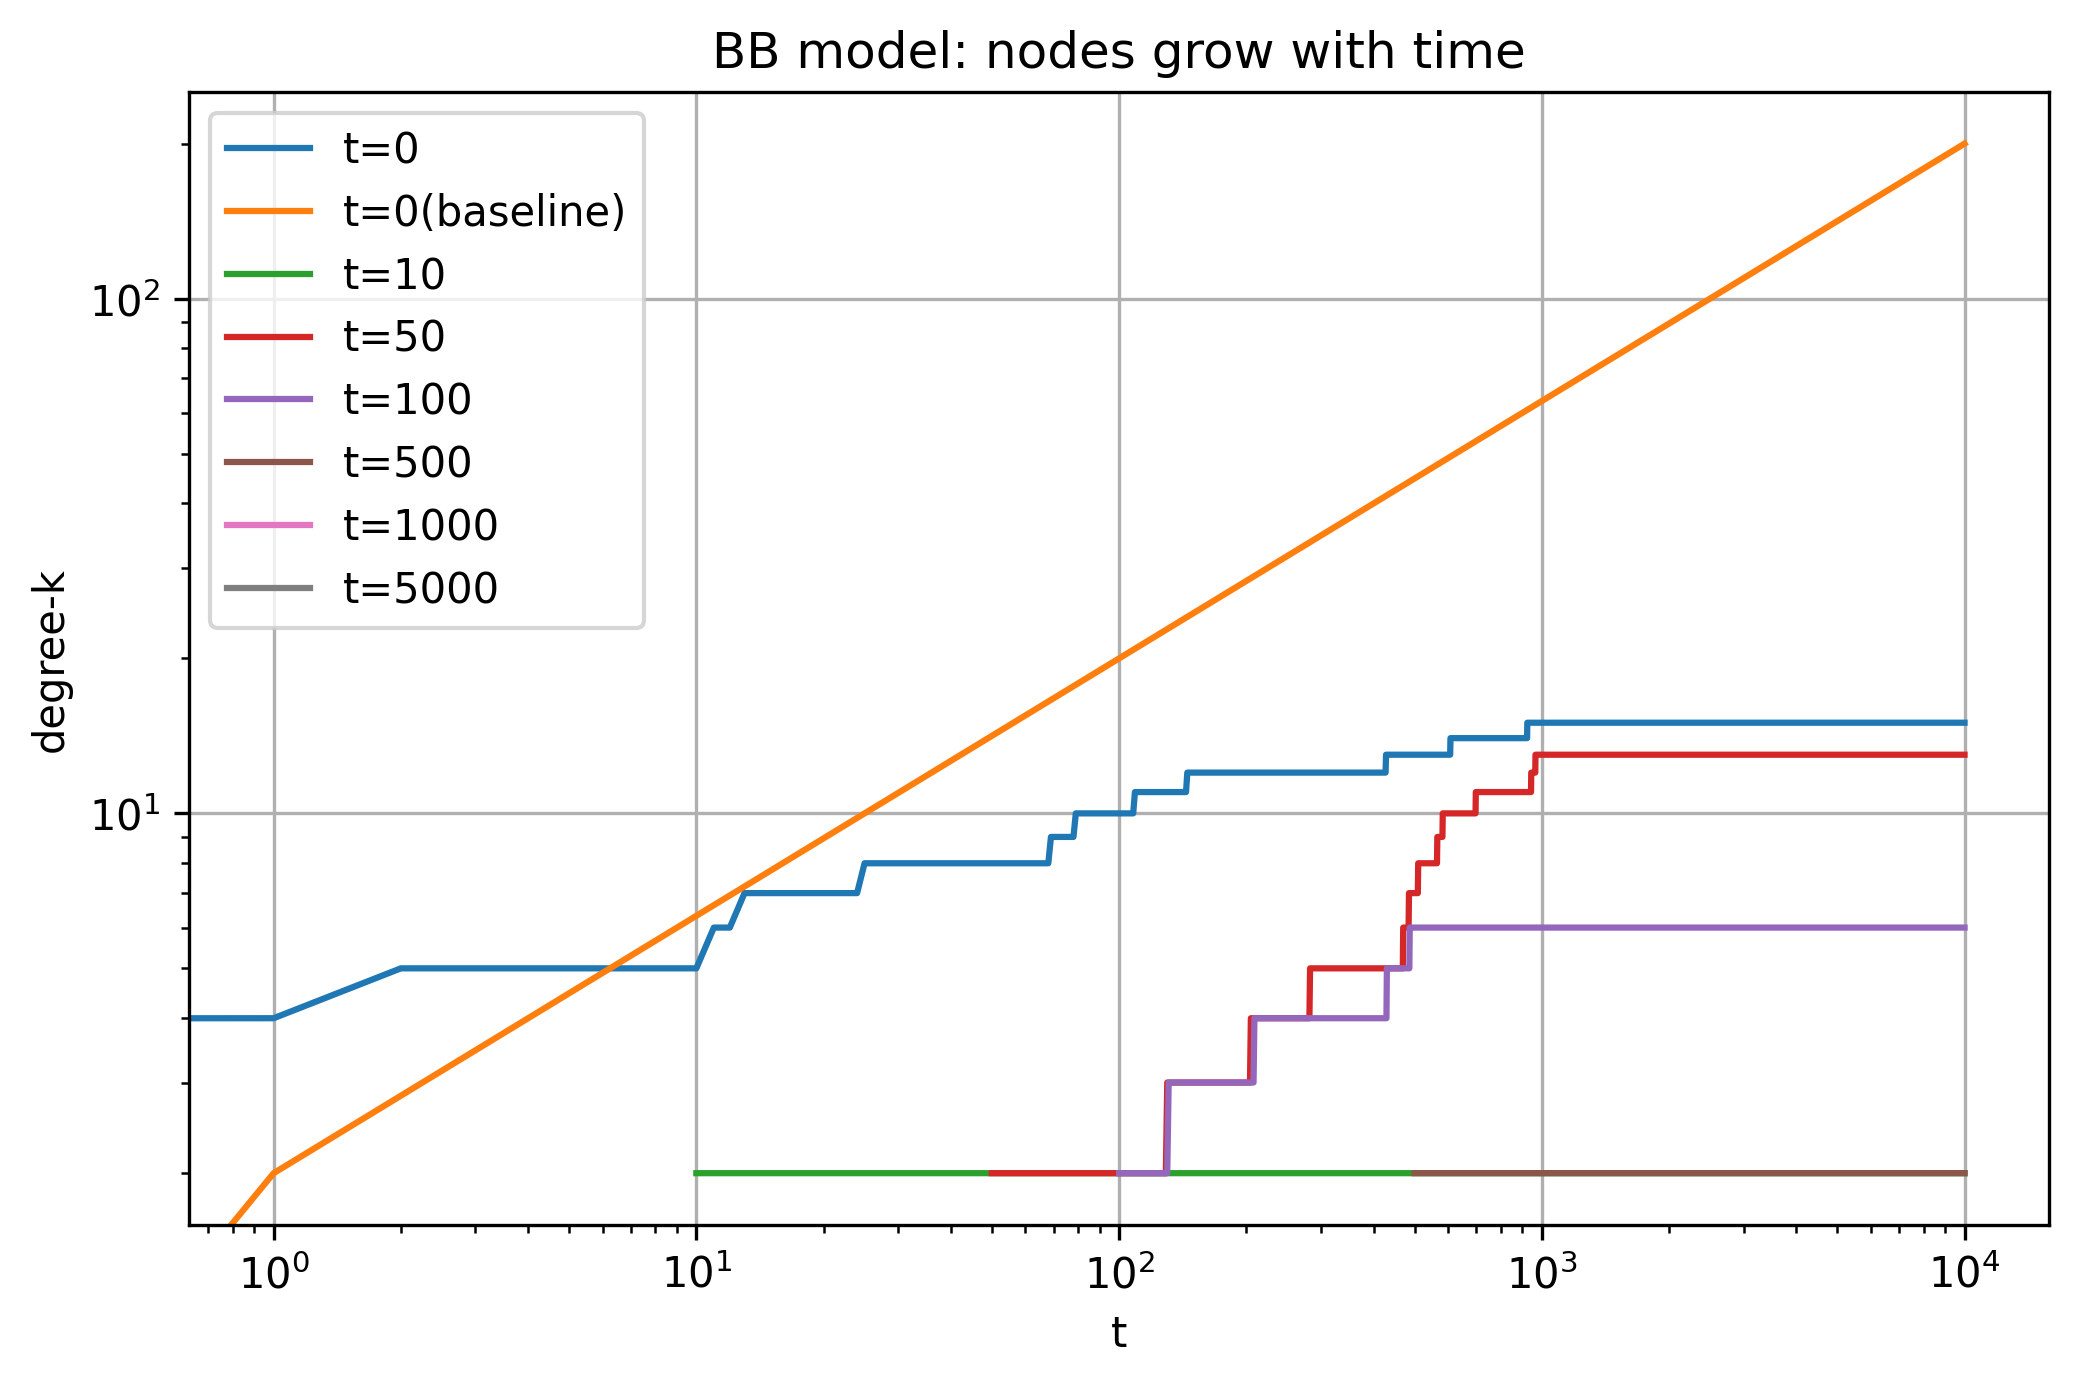

In [78]:
plt.figure(dpi=300,figsize=(8,5))
plt.title("BB model: nodes grow with time")
plt.xscale("log")
plt.yscale("log")
#添加画布内容
plt.xlabel('t',)  #通过提前预制的font字典，设置中文字体
plt.ylabel('degree-k')
x,y=degree_increase()
plt.plot(x,y)
#理论值page203，公式4.7，beita=1/2这个承睿也检查时否对
y=m*np.float_power(x,0.5)
plt.plot(x,y)


x,y=degree_increase(10)
plt.plot(x,y)
x,y=degree_increase(50)
plt.plot(x,y)
x,y=degree_increase(100)
plt.plot(x,y)
x,y=degree_increase(500)
plt.plot(x,y)
x,y=degree_increase(1000)
plt.plot(x,y)
x,y=degree_increase(5000)
plt.plot(x,y)
#增加图例
plt.legend(["t=0","t=0(baseline)","t=10",'t=50','t=100','t=500','t=1000','t=5000'])   ##增加图例
#plt.grid() #给， x,y轴同时添加网格线
plt.grid(axis='x') #在 x轴添加网格线
plt.grid(axis='y') #在 y轴添加网格线
#线性比较，证明BA网络的亚线性增长
# x=np.linspace(0,500,500)
# y=x
# plt.plot(x,y,linestyle='--')

### 步骤2 网络中度分布的观察

pk = k^(1+C) / lnk

In [79]:
def get_Pk(k,gama=2.225):
    global m  #每个节点，加入时刻带来的边数量
    #np.float_power  np.float_power(5, -2)
    return np.float_power(k,-gama) / np.log10(k)

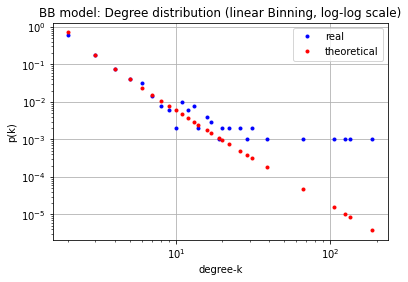

In [80]:
k_list=[]
pk_list=[]
c=Counter(nodes.d)
#按照值从小到大排序
cc=sorted(c.items(),key=lambda x:x[0]) 
#print(cc)
#线性标度图
for tmpk_nums in cc:
    k_list.append(tmpk_nums[0])
    pk_list.append(tmpk_nums[1]/len(nodes))
plt.title('BB model: Degree distribution (linear Binning, log-log scale)')

#添加画布内容
plt.xlabel('degree-k',)  #通过提前预制的font字典，设置中文字体
plt.ylabel('p(k)')
#双对数坐标-----线性分箱---观察值
plt.xscale("log")
plt.yscale("log")
plt.plot(k_list,pk_list,"b.")
#双对数坐标-----线性分箱---理论值
pk_list=get_Pk(k_list)
plt.plot(k_list,pk_list,"r.")
plt.legend(["real","theoretical"])   ##增加图例
#plt.grid() #给， x,y轴同时添加网格线
plt.grid(axis='x') #在 x轴添加网格线
plt.grid(axis='y') #在 y轴添加网格线



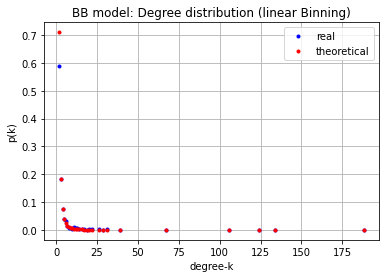

In [81]:
#普通坐标-----线性分箱---理论值
#线性标度图
k_list=[]
pk_list=[]
for tmpk_nums in cc:
    k_list.append(tmpk_nums[0])
    pk_list.append(tmpk_nums[1]/len(nodes))
#双对数坐标-----线性分箱---观察值
k_list=np.array(k_list)
plt.title('BB model: Degree distribution (linear Binning)')
#添加画布内容
plt.xlabel('degree-k',)  #通过提前预制的font字典，设置中文字体
plt.ylabel('p(k)')
plt.plot(k_list,pk_list,"b.")
#双对数坐标-----线性分箱---理论值
pk_list=get_Pk(k_list)
plt.plot(k_list,pk_list,"r.")
plt.legend(["real","theoretical"])   ##增加图例
#plt.grid() #给， x,y轴同时添加网格线
plt.grid(axis='x') #在 x轴添加网格线
plt.grid(axis='y') #在 y轴添加网格线